In [ ]:
# Testing significance of difference in performance when using wiring cost control
# For details, please see Sec. V of SI of "Brain-inspired wiring economics for artificial neural networks", by Xinjie Zhang et al.
# 
# Jack Murdoch Moore
# August 2024

In [1]:
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt
import json# Loading and saving data

#Saving data
def save(save_str, save_dict):
    with open(save_str + '.json', 'w', encoding='utf-8') as json_file:
        json.dump(save_dict, json_file, ensure_ascii=False)

In [2]:
file_name_left = '.\\original data\\'
model_list = ['GRU', 'RNN']
dataset_list = ['HAR', 'HGS', 'MNIST', 'DMTask', 'ManteTask']
rewiring_list = ['DeepR', 'DSR', 'SET']
# training_list = ['L1', 'L1-wiring-cost']#
training_list = ['L2', 'L2-wiring-cost']

init_time = time.time()

# t-test for observation:
z_list_0 = []
z_list_1 = []
for model in model_list:
    for dataset in dataset_list:
        if (model == 'GRU'):
            if ((dataset == 'DMTask') or (dataset == 'ManteTask')):
                continue
        for rewiring in rewiring_list:
            performance_list_list = []
            for training in training_list:
                file_name = file_name_left + model + '-' + dataset + '-' + rewiring + '-' + training + '.txt'
                performance_list = list(np.loadtxt(file_name))
                performance_list_list = performance_list_list + [performance_list]
            z_list_list = scipy.stats.zscore(performance_list_list, axis=None, ddof=0)#Z-scores using population standard deviation
            z_list_0 = z_list_0 + list(z_list_list[0])
            z_list_1 = z_list_1 + list(z_list_list[1])
res_obs = scipy.stats.ttest_ind(z_list_1, z_list_0, equal_var=True, alternative='greater')
t_obs = res_obs.statistic
p_obs = res_obs.pvalue
mean_z_0 = np.mean(z_list_0)
mean_z_1 = np.mean(z_list_1)

# t-test for surrogates (randomly redistribute values):
num_surr = 99999
t_surr_list = np.zeros(num_surr)
p_surr_list = np.zeros(num_surr)
for i_surr in range(num_surr):
    z_surr_list_0 = []
    z_surr_list_1 = []
    for model in model_list:
        for dataset in dataset_list:
            if (model == 'GRU'):
                if ((dataset == 'DMTask') or (dataset == 'ManteTask')):
                    continue
            for rewiring in rewiring_list:
                performance_list_list = []
                for training in training_list:
                    file_name = file_name_left + model + '-' + dataset + '-' + rewiring + '-' + training + '.txt'
                    performance_list = list(np.loadtxt(file_name))
                    performance_list_list = performance_list_list + [performance_list]
                #Randomise assignment to Li or Li-wiring-cost:
                performance_surr_list_long = performance_list_list[0] + performance_list_list[1]
                np.random.shuffle(performance_surr_list_long)
                num_trials = len(performance_list)
                performance_surr_list_list = [performance_surr_list_long[:num_trials]] + [performance_surr_list_long[num_trials:]]
                z_surr_list_list = scipy.stats.zscore(performance_surr_list_list, axis=None, ddof=0)#Z-scores using population standard deviation
                z_surr_list_0 = z_surr_list_0 + list(z_surr_list_list[0])
                z_surr_list_1 = z_surr_list_1 + list(z_surr_list_list[1])
    res_surr = scipy.stats.ttest_ind(z_surr_list_1, z_surr_list_0, equal_var=True, alternative='greater')
    t_surr = res_surr.statistic
    p_surr = res_surr.pvalue
    t_surr_list[i_surr] = t_surr
    p_surr_list[i_surr] = p_surr
    
mean_t_surr = np.mean(t_surr_list)
std_t_surr = np.std(t_surr_list)
    
p = (sum(t_obs <= t_surr_list) + 1)/(num_surr + 1)

final_time = time.time()
total_time = final_time - init_time
print('That took ' + str(total_time) + ' sec.')

print('H0: Performance of ' + training_list[1] + ' and ' + training_list[0] + ' are drawn from the same distribution')
print('H1: Performance of ' + training_list[1] + ' higher than ' + training_list[0])
print('p = ' + str(p))

save_str = 'stat-analysis_' + str(num_surr) + 'surr_' + training_list[0]

# Save results

save_dict = {'training_list':training_list,
             'model_list':model_list,
             'dataset_list':dataset_list,
             'rewiring_list':rewiring_list,
             'z_list_0':z_list_0,
             'z_list_1':z_list_1,
             'mean_z_0':mean_z_0,
             'mean_z_1':mean_z_1,
             't_obs':t_obs,
             'p_obs':p_obs,
             'num_surr':num_surr,
             't_surr_list':t_surr_list.tolist(),
             'p_surr_list':p_surr_list.tolist(),
             'mean_t_surr':mean_t_surr,
             'std_t_surr':std_t_surr,
             'p':p,
             'total_time':total_time,
             'save_str':save_str,
}

save(save_str, save_dict)

That took 1717.3164160251617 sec.
H0: Performance of L2-wiring-cost and L2 are drawn from the same distribution
H1: Performance of L2-wiring-cost higher than L2
p = 0.00038


In [13]:
#Convert results in .json format to .txt format

import json# Loading and saving data
import numpy as np

#Load saved results
# save_str = 'stat-analysis_999999surr_L1'
save_str = 'stat-analysis_999999surr_L2'
with open(save_str + '.json', 'r') as read_file:
    save_dict = json.load(read_file)

training_list = save_dict['training_list']
model_list = save_dict['model_list']
dataset_list = save_dict['dataset_list']
rewiring_list = save_dict['rewiring_list']
z_list_0 = save_dict['z_list_0'],
z_list_1 = save_dict['z_list_1'],
mean_z_0 = save_dict['mean_z_0']
mean_z_1 = save_dict['mean_z_1']
t_obs = save_dict['t_obs']
p_obs = save_dict['p_obs']
num_surr = save_dict['num_surr']
t_surr_list = save_dict['t_surr_list']
p_surr_list = save_dict['p_surr_list']
mean_t_surr = save_dict['mean_t_surr']
std_t_surr = save_dict['std_t_surr']
p = save_dict['p']
total_time = save_dict['total_time']
save_str = save_dict['save_str']

np.savetxt(save_str + '_' + 'z_list_1' + '.txt', z_list_1)
np.savetxt(save_str + '_' + 'z_list_0' + '.txt', z_list_0)
np.savetxt(save_str + '_' + 't_obs' + '.txt', [t_obs])
np.savetxt(save_str + '_' + 'p_obs' + '.txt', [p_obs])
np.savetxt(save_str + '_' + 't_surr_list' + '.txt', t_surr_list)
np.savetxt(save_str + '_' + 'p_surr_list' + '.txt', p_surr_list)
np.savetxt(save_str + '_' + 'p' + '.txt', [p])

That took 16682.526892900467 sec.

Mean z-score under L1: -0.21536427042015618
Mean z-score under L1-wiring-cost: 0.2153642704201564


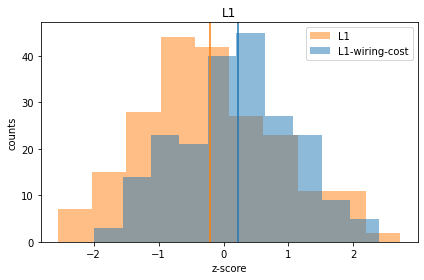

Observed: t = 4.508940687613596; naive p = 4.236701316788509e-06
Surrogates: mean t = 0.000654734550407883; (population) stand. dev. = 1.0321261806421853

H0: Performance of L1-wiring-cost and L1 are drawn from the same distribution
H1: Performance of L1-wiring-cost higher than L1
p = 9e-06


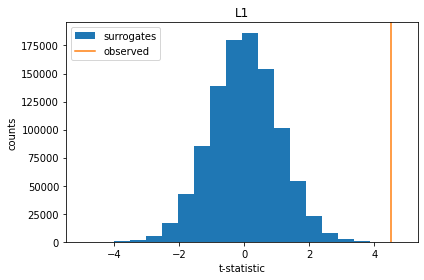

In [2]:
#Load saved results
save_str = 'stat-analysis_999999surr_L1'
with open(save_str + '.json', 'r') as read_file:
    save_dict = json.load(read_file)

training_list = save_dict['training_list']
model_list = save_dict['model_list']
dataset_list = save_dict['dataset_list']
rewiring_list = save_dict['rewiring_list']
z_list_0 = save_dict['z_list_0'],
z_list_1 = save_dict['z_list_1'],
mean_z_0 = save_dict['mean_z_0']
mean_z_1 = save_dict['mean_z_1']
t_obs = save_dict['t_obs']
p_obs = save_dict['p_obs']
num_surr = save_dict['num_surr']
t_surr_list = save_dict['t_surr_list']
p_surr_list = save_dict['p_surr_list']
mean_t_surr = save_dict['mean_t_surr']
std_t_surr = save_dict['std_t_surr']
p = save_dict['p']
total_time = save_dict['total_time']
save_str = save_dict['save_str']

# Make plots

print('That took ' + str(total_time) + ' sec.\n')
print('Mean z-score under ' + training_list[0] + ': ' + str(mean_z_0))
print('Mean z-score under ' + training_list[1] + ': ' + str(mean_z_1))

fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
hist = ax.hist(z_list_0, bins=10, label=training_list[0], alpha=0.5, color='tab:orange')
hist = ax.hist(z_list_1, bins=10, label=training_list[1], alpha=0.5, color='tab:blue')
y_lim = ax.get_ylim()
ax.plot([mean_z_0, mean_z_0], list(y_lim), color='tab:orange')
ax.plot([mean_z_1, mean_z_1], list(y_lim), color='tab:blue')
ax.set_ylim(y_lim)
ax.set_xlabel('z-score')
ax.set_ylabel('counts')
ax.set_title(training_list[0])
ax.legend()
plt.savefig('z-score-' + training_list[0] + '.png')
plt.show()

print('Observed: t = ' + str(t_obs) + '; naive p = ' + str(p_obs))
print('Surrogates: mean t = ' + str(mean_t_surr) + '; (population) stand. dev. = ' + str(std_t_surr) + '\n')

print('H0: Performance of ' + training_list[1] + ' and ' + training_list[0] + ' are drawn from the same distribution')
print('H1: Performance of ' + training_list[1] + ' higher than ' + training_list[0])
print('p = ' + str(p))

fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
hist = ax.hist(t_surr_list, bins=20, label='surrogates')
y_lim = ax.get_ylim()
ax.plot([t_obs, t_obs], list(y_lim), label='observed')
ax.set_ylim(y_lim)
ax.set_xlabel('t-statistic')
ax.set_ylabel('counts')
ax.set_title(training_list[0])
ax.legend()
plt.savefig('t-stat-' + training_list[0] + '.png')
plt.show()

That took 16752.257269382477 sec.

Mean z-score under L2: -0.16979812233310743
Mean z-score under L2-wiring-cost: 0.16979812233310398


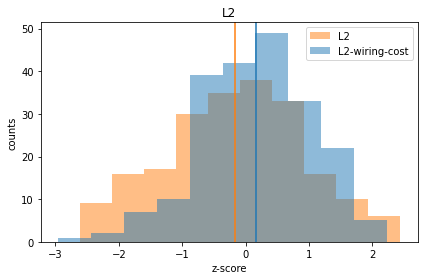

Observed: t = 3.522684177225479; naive p = 0.00023715003045502226
Surrogates: mean t = 0.00042098059429701145; (population) stand. dev. = 1.0312774679944687

H0: Performance of L2-wiring-cost and L2 are drawn from the same distribution
H1: Performance of L2-wiring-cost higher than L2
p = 0.000327


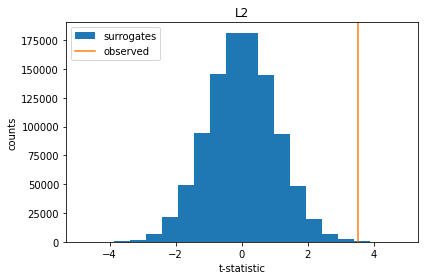

In [3]:
#Load saved results
save_str = 'stat-analysis_999999surr_L2'
with open(save_str + '.json', 'r') as read_file:
    save_dict = json.load(read_file)

training_list = save_dict['training_list']
model_list = save_dict['model_list']
dataset_list = save_dict['dataset_list']
rewiring_list = save_dict['rewiring_list']
z_list_0 = save_dict['z_list_0'],
z_list_1 = save_dict['z_list_1'],
mean_z_0 = save_dict['mean_z_0']
mean_z_1 = save_dict['mean_z_1']
t_obs = save_dict['t_obs']
p_obs = save_dict['p_obs']
num_surr = save_dict['num_surr']
t_surr_list = save_dict['t_surr_list']
p_surr_list = save_dict['p_surr_list']
mean_t_surr = save_dict['mean_t_surr']
std_t_surr = save_dict['std_t_surr']
p = save_dict['p']
total_time = save_dict['total_time']
save_str = save_dict['save_str']

# Make plots

print('That took ' + str(total_time) + ' sec.\n')
print('Mean z-score under ' + training_list[0] + ': ' + str(mean_z_0))
print('Mean z-score under ' + training_list[1] + ': ' + str(mean_z_1))

fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
hist = ax.hist(z_list_0, bins=10, label=training_list[0], alpha=0.5, color='tab:orange')
hist = ax.hist(z_list_1, bins=10, label=training_list[1], alpha=0.5, color='tab:blue')
y_lim = ax.get_ylim()
ax.plot([mean_z_0, mean_z_0], list(y_lim), color='tab:orange')
ax.plot([mean_z_1, mean_z_1], list(y_lim), color='tab:blue')
ax.set_ylim(y_lim)
ax.set_xlabel('z-score')
ax.set_ylabel('counts')
ax.set_title(training_list[0])
ax.legend()
plt.savefig('z-score-' + training_list[0] + '.png')
plt.show()

print('Observed: t = ' + str(t_obs) + '; naive p = ' + str(p_obs))
print('Surrogates: mean t = ' + str(mean_t_surr) + '; (population) stand. dev. = ' + str(std_t_surr) + '\n')

print('H0: Performance of ' + training_list[1] + ' and ' + training_list[0] + ' are drawn from the same distribution')
print('H1: Performance of ' + training_list[1] + ' higher than ' + training_list[0])
print('p = ' + str(p))

fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
hist = ax.hist(t_surr_list, bins=20, label='surrogates')
y_lim = ax.get_ylim()
ax.plot([t_obs, t_obs], list(y_lim), label='observed')
ax.set_ylim(y_lim)
ax.set_xlabel('t-statistic')
ax.set_ylabel('counts')
ax.set_title(training_list[0])
ax.legend()
plt.savefig('t-stat-' + training_list[0] + '.png')
plt.show()